# Profiling of `maze_dataset` serializing/loading/saving/reading

In [1]:
import copy
import itertools
import warnings
from typing import Any, Callable, Sequence

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from muutils.statcounter import StatCounter
from muutils.timeit_fancy import FancyTimeitResult, timeit_fancy

from maze_dataset import (
	MazeDataset,
	MazeDatasetConfig,
	set_serialize_minimal_threshold,
)
from maze_dataset.generation.generators import GENERATORS_MAP

## Generate Datasets


In [2]:
cfgs: list[MazeDatasetConfig] = [
	MazeDatasetConfig(
		name="test",
		grid_n=grid_n,
		n_mazes=n_mazes,
		maze_ctor=GENERATORS_MAP["gen_dfs"],
	)
	for grid_n, n_mazes in itertools.product(
		[10],
		np.logspace(1, 2, 2, dtype=int).tolist(),  # 100, for CI tests
		# np.logspace(1, 3, 5, dtype=int).tolist(), # 1k
		# np.logspace(0, 4, 9, dtype=int).tolist(), # 10k, notebook results from this set
	)
]

datasets: list[MazeDataset] = [
	MazeDataset.from_config(cfg, load_local=False) for cfg in cfgs
]

## Profile

In [3]:
columns: list[str] = [
	"grid_n",
	"n_mazes",
	"serialize",
	"serialize_minimal",
	"load",
	"load_minimal",
	"save",
	"save_minimal",
	"read",
	"read_minimal",
]
speeds_data: list[dict] = list()

In [4]:
def wrapped_timeit_fancy(
	name: str,
	function: Callable,
	do_profiling: bool,
	repeats: int,
	timing_stat: Callable[[StatCounter], float],
) -> tuple[dict, Any]:
	output: dict = dict()

	result: FancyTimeitResult = timeit_fancy(
		function,
		get_return=True,
		do_profiling=do_profiling,
		repeats=repeats,
	)

	output[name] = timing_stat(result.timings)
	output[f"{name}:stats"] = result.timings
	if do_profiling:
		output[f"{name}:profiling"] = result.profile

	return output, result.return_value


def measure_dataset_speed(
	d: MazeDataset,
	do_profiling: bool = True,
	repeats: int = 1,
	timing_stat: Callable[[StatCounter], float] = StatCounter.min,
) -> dict:
	if repeats > 1:
		warnings.warn(
			"Repeats > 1, results might not be accurate due to generation metadata being collected.",
		)
	kwargs_fancy_timeit: dict = dict(
		do_profiling=do_profiling,
		timing_stat=timing_stat,
		repeats=repeats,
	)
	set_serialize_minimal_threshold(None)
	_d_cpy: MazeDataset = copy.deepcopy(d)
	# set up row data
	row_data: dict = dict(
		grid_n=d.cfg.grid_n,
		n_mazes=d.cfg.n_mazes,
	)
	# serialization & loading
	info_serialize, result_serialize = wrapped_timeit_fancy(
		"serialize_full",
		_d_cpy._serialize_full,
		**kwargs_fancy_timeit,
	)
	row_data.update(info_serialize)
	_d_cpy = copy.deepcopy(d)

	info_serialize_min, result_serialize_min = wrapped_timeit_fancy(
		"serialize_minimal",
		_d_cpy._serialize_minimal,
		**kwargs_fancy_timeit,
	)
	row_data.update(info_serialize_min)
	_d_cpy = copy.deepcopy(d)

	# info_serialize_min_alt, result_serialize_min_alt = wrapped_timeit_fancy(
	#     'serialize_minimal_alt', _d_cpy._serialize_minimal_alt, **kwargs_fancy_timeit
	# )
	# row_data.update(info_serialize_min_alt)
	_d_cpy = copy.deepcopy(d)
	info_serialize_cat, result_serialize_cat = wrapped_timeit_fancy(
		"serialize_minimal_soln_cat",
		_d_cpy._serialize_minimal_soln_cat,
		**kwargs_fancy_timeit,
	)
	row_data.update(info_serialize_cat)
	_d_cpy = copy.deepcopy(d)

	row_data.update(
		wrapped_timeit_fancy(
			"load_legacy",
			lambda: MazeDataset._load_legacy(result_serialize),
			**kwargs_fancy_timeit,
		)[0],
	)
	row_data.update(
		wrapped_timeit_fancy(
			"load_full",
			lambda: MazeDataset._load_full(result_serialize),
			**kwargs_fancy_timeit,
		)[0],
	)
	row_data.update(
		wrapped_timeit_fancy(
			"load_minimal",
			lambda: MazeDataset._load_minimal(result_serialize_min),
			**kwargs_fancy_timeit,
		)[0],
	)
	row_data.update(
		wrapped_timeit_fancy(
			"load_minimal_soln_cat",
			lambda: MazeDataset._load_minimal_soln_cat(result_serialize_cat),
			**kwargs_fancy_timeit,
		)[0],
	)

	row_data.update(
		wrapped_timeit_fancy(
			"load_full",
			lambda: MazeDataset._load_full(result_serialize),
			**kwargs_fancy_timeit,
		)[0],
	)
	row_data.update(
		wrapped_timeit_fancy(
			"load_minimal",
			lambda: MazeDataset._load_minimal(result_serialize_min),
			**kwargs_fancy_timeit,
		)[0],
	)
	row_data.update(
		wrapped_timeit_fancy(
			"load_minimal_soln_cat",
			lambda: MazeDataset._load_minimal_soln_cat(result_serialize_cat),
			**kwargs_fancy_timeit,
		)[0],
	)

	# saving and loading
	path_default: str = f"../data/{d.cfg.to_fname()}.zanj"
	path_min: str = f"../data/{d.cfg.to_fname()}_min.zanj"

	# default
	set_serialize_minimal_threshold(None)
	_d_cpy = copy.deepcopy(d)
	row_data.update(
		wrapped_timeit_fancy(
			"save",
			lambda: _d_cpy.save(file_path=path_default),
			**kwargs_fancy_timeit,
		)[0],
	)
	_d_cpy = copy.deepcopy(d)

	# read_legacy
	set_serialize_minimal_threshold(-1)
	row_data.update(
		wrapped_timeit_fancy(
			"read_legacy",
			lambda: MazeDataset.read(file_path=path_default),
			**kwargs_fancy_timeit,
		)[0],
	)

	# default read
	set_serialize_minimal_threshold(None)
	row_data.update(
		wrapped_timeit_fancy(
			"read",
			lambda: MazeDataset.read(file_path=path_default),
			**kwargs_fancy_timeit,
		)[0],
	)

	# minimal
	set_serialize_minimal_threshold(0)
	_d_cpy = copy.deepcopy(d)
	row_data.update(
		wrapped_timeit_fancy(
			"save_minimal",
			lambda: _d_cpy.save(file_path=path_min),
			**kwargs_fancy_timeit,
		)[0],
	)
	_d_cpy = copy.deepcopy(d)

	row_data.update(
		wrapped_timeit_fancy(
			"read_minimal",
			lambda: MazeDataset.read(file_path=path_min),
			**kwargs_fancy_timeit,
		)[0],
	)

	# asserts
	# assert d == read_default
	# assert d == read_minimal

	# reset cfg?
	set_serialize_minimal_threshold(None)

	return row_data

## Run Profiling

In [5]:
for i, d in enumerate(datasets):
	print(f"Profiling {i + 1}/{len(datasets)}:\t{d.cfg}")
	result = measure_dataset_speed(d)
	speeds_data.append(result)
	cols_short: str = str({k: v for k, v in result.items() if ":" not in k})
	print(f"\t{cols_short}")
	print(f"\t{d.cfg!s}")

Profiling 1/2:	MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=10, n_mazes=10, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x7aac4c8ca2a0>, maze_ctor_kwargs={}, endpoint_kwargs={})
	{'grid_n': 10, 'n_mazes': 10, 'serialize_full': 0.0018484899992472492, 'serialize_minimal': 0.003223842999432236, 'serialize_minimal_soln_cat': 0.0014313210049294867, 'load_legacy': 0.005206369998631999, 'load_full': 0.001840072996856179, 'load_minimal': 0.000822582995169796, 'load_minimal_soln_cat': 0.003138806998322252, 'save': 0.046455591000267304, 'read_legacy': 0.018541731005825568, 'read': 0.01719445599883329, 'save_minimal': 0.0133227159967646, 'read_minimal': 0.0011167789998580702}
	MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=10, n_mazes=10, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x7aac4c8ca2a0>, maze_ctor_kwargs={}, endpoint_kwargs={})
Profiling 2/2:	MazeDatasetConfig(nam

### Results

In [6]:
SPEEDS: pd.DataFrame = pd.DataFrame(speeds_data)

SPEEDS

,grid_n,n_mazes,serialize_full,serialize_full:stats,serialize_full:profiling,serialize_minimal,serialize_minimal:stats,serialize_minimal:profiling,serialize_minimal_soln_cat,serialize_minimal_soln_cat:stats,...,read_legacy:profiling,read,read:stats,read:profiling,save_minimal,save_minimal:stats,save_minimal:profiling,read_minimal,read_minimal:stats,read_minimal:profiling
0,10,10,0.001848,{0.0018484899992472492: 1},<pstats.Stats object at 0x7aad5a182690>,0.003224,{0.003223842999432236: 1},<pstats.Stats object at 0x7aac4912ac00>,0.001431,{0.0014313210049294867: 1},...,<pstats.Stats object at 0x7aac4912a4b0>,0.017194,{0.01719445599883329: 1},<pstats.Stats object at 0x7aac490201d0>,0.013323,{0.0133227159967646: 1},<pstats.Stats object at 0x7aac49162cf0>,0.001117,{0.0011167789998580702: 1},<pstats.Stats object at 0x7aad117235c0>
1,10,100,0.001027,{0.0010271579958498478: 1},<pstats.Stats object at 0x7aac49163f80>,0.001022,{0.001022066004225053: 1},<pstats.Stats object at 0x7aac49129c40>,0.001121,{0.001120972003263887: 1},...,<pstats.Stats object at 0x7aac49023110>,0.012402,{0.012401505002344493: 1},<pstats.Stats object at 0x7aac49161e50>,0.014304,{0.014303780000773259: 1},<pstats.Stats object at 0x7aac4d392660>,0.002064,{0.0020644929973059334: 1},<pstats.Stats object at 0x7aac48f31040>


In [7]:
def compute_speedups(speeds: pd.DataFrame) -> pd.DataFrame:
	# for prefix in column_measurement_prefixes:
	#     speeds[f'{prefix}_speedup'] = speeds[f'{prefix}_full'] / speeds[f'{prefix}_minimal']
	speeds["serialize/speedup"] = speeds["serialize_full"] / speeds["serialize_minimal"]
	speeds["load/speedup"] = speeds["load_full"] / speeds["load_minimal"]
	speeds["save/speedup"] = speeds["save"] / speeds["save_minimal"]
	speeds["read/speedup"] = speeds["read"] / speeds["read_minimal"]

	return speeds


SPEEDS = compute_speedups(SPEEDS)

In [8]:
SPEEDS: pd.DataFrame = pd.DataFrame(speeds_data)

# SPEEDS.loc[:,"load_legacy":"load_minimal_soln_cat:profiling"]
SPEEDS.loc[:, "read_legacy":"read:profiling"]

,read_legacy,read_legacy:stats,read_legacy:profiling,read,read:stats,read:profiling
0,0.018542,{0.018541731005825568: 1},<pstats.Stats object at 0x7aac4912a4b0>,0.017194,{0.01719445599883329: 1},<pstats.Stats object at 0x7aac490201d0>
1,0.020691,{0.020691411002189852: 1},<pstats.Stats object at 0x7aac49023110>,0.012402,{0.012401505002344493: 1},<pstats.Stats object at 0x7aac49161e50>


In [9]:
SPEEDS.columns

Index(['grid_n', 'n_mazes', 'serialize_full', 'serialize_full:stats',
       'serialize_full:profiling', 'serialize_minimal',
       'serialize_minimal:stats', 'serialize_minimal:profiling',
       'serialize_minimal_soln_cat', 'serialize_minimal_soln_cat:stats',
       'serialize_minimal_soln_cat:profiling', 'load_legacy',
       'load_legacy:stats', 'load_legacy:profiling', 'load_full',
       'load_full:stats', 'load_full:profiling', 'load_minimal',
       'load_minimal:stats', 'load_minimal:profiling', 'load_minimal_soln_cat',
       'load_minimal_soln_cat:stats', 'load_minimal_soln_cat:profiling',
       'save', 'save:stats', 'save:profiling', 'read_legacy',
       'read_legacy:stats', 'read_legacy:profiling', 'read', 'read:stats',
       'read:profiling', 'save_minimal', 'save_minimal:stats',
       'save_minimal:profiling', 'read_minimal', 'read_minimal:stats',
       'read_minimal:profiling'],
      dtype='object')

In [10]:
def compute_speedups(speeds: pd.DataFrame) -> pd.DataFrame:
	# for prefix in column_measurement_prefixes:
	#     speeds[f'{prefix}_speedup'] = speeds[f'{prefix}_full'] / speeds[f'{prefix}_minimal']
	speeds["serialize/speedup"] = speeds["serialize_full"] / speeds["serialize_minimal"]
	speeds["load_minimal/speedup"] = speeds["load_legacy"] / speeds["load_minimal"]
	speeds["load/speedup"] = speeds["load_legacy"] / speeds["load_full"]
	speeds["save/speedup"] = speeds["save"] / speeds["save_minimal"]
	speeds["read_minimal/speedup"] = speeds["read_legacy"] / speeds["read_minimal"]
	speeds["read/speedup"] = speeds["read_legacy"] / speeds["read"]

	return speeds


SPEEDS = compute_speedups(SPEEDS)

In [11]:
SPEEDS[[c for c in SPEEDS.columns if ":" not in c]]

,grid_n,n_mazes,serialize_full,serialize_minimal,serialize_minimal_soln_cat,load_legacy,load_full,load_minimal,load_minimal_soln_cat,save,read_legacy,read,save_minimal,read_minimal,serialize/speedup,load_minimal/speedup,load/speedup,save/speedup,read_minimal/speedup,read/speedup
0,10,10,0.001848,0.003224,0.001431,0.005206,0.001840,0.000823,0.003139,0.046456,0.018542,0.017194,0.013323,0.001117,0.573381,6.329294,2.829437,3.486946,16.602865,1.078355
1,10,100,0.001027,0.001022,0.001121,0.009384,0.007477,0.001196,0.004774,0.106153,0.020691,0.012402,0.014304,0.002064,1.004982,7.848028,1.255140,7.421329,10.022515,1.668460


Plotting serialize timings and speedups
Plotting grid_n=10
Plotting load timings and speedups
Plotting grid_n=10
Plotting save timings and speedups
Plotting grid_n=10
Plotting read timings and speedups
Plotting grid_n=10


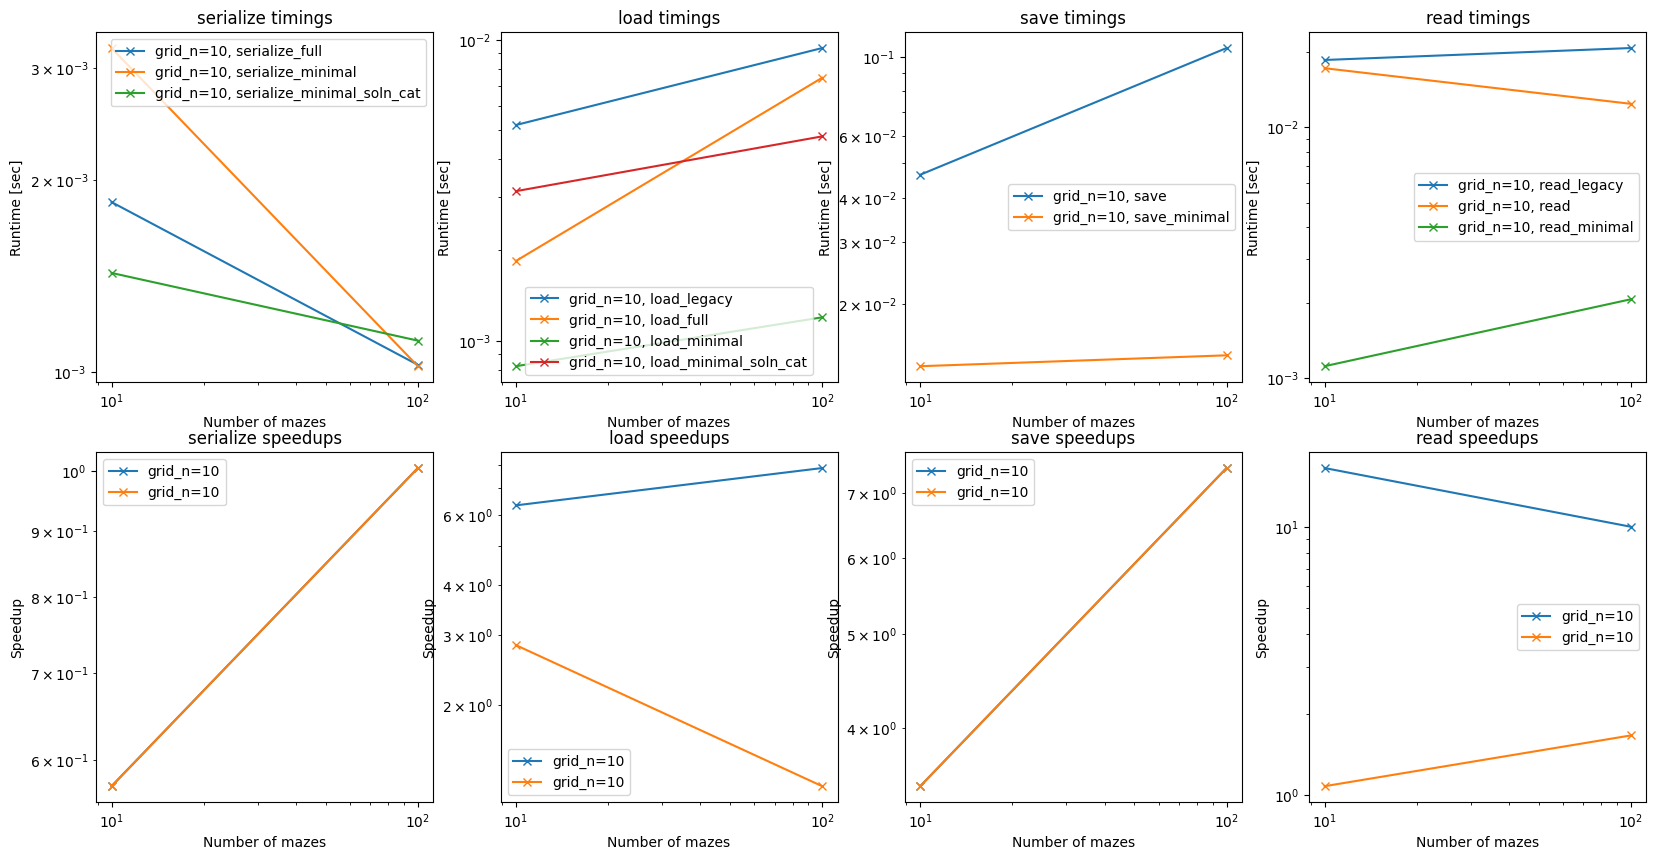

In [12]:
def plot_speeds(
	speeds: pd.DataFrame,
	column_measurement_prefixes: Sequence[str] = ("serialize", "load", "save", "read"),
) -> None:
	n_measurements: int = len(column_measurement_prefixes)
	fig, axs = plt.subplots(2, n_measurements, figsize=(n_measurements * 5, 10))

	unique_grid_ns: list[int] = speeds["grid_n"].unique().tolist()

	for i, prefix in enumerate(column_measurement_prefixes):
		print(f"Plotting {prefix} timings and speedups")
		for grid_n in unique_grid_ns:
			print(f"Plotting grid_n={grid_n}")
			# raw timings
			ax_timings = axs[0, i]
			speeds_masked = speeds[speeds["grid_n"] == grid_n].sort_values("n_mazes")
			x_n_mazes = speeds_masked["n_mazes"]

			# Plotting
			for col in speeds_masked.columns:
				if (prefix in col) and ("speedup" not in col) and (":" not in col):
					ax_timings.plot(
						x_n_mazes,
						speeds_masked[col],
						"x-",
						label=f"grid_n={grid_n}, {col}",
					)

			# Setting multiple properties with `set`
			ax_timings.set(
				xscale="log",
				yscale="log",
				xlabel="Number of mazes",
				ylabel="Runtime [sec]",
				title=f"{prefix} timings",
			)
			ax_timings.legend()

			# speedups
			ax_speedups = axs[1, i]
			col_name: str = (
				f"{prefix}" if prefix in ("serialize", "save") else f"{prefix}_minimal"
			)
			ax_speedups.plot(
				x_n_mazes,
				speeds_masked[f"{col_name}/speedup"],
				"x-",
				label=f"grid_n={grid_n}",
			)

			# Setting multiple properties with `set` for ax_speedups
			ax_speedups.set(
				xscale="log",
				yscale="log",
				xlabel="Number of mazes",
				ylabel="Speedup",
				title=f"{col_name} speedups",
			)
			ax_speedups.plot(
				x_n_mazes,
				speeds_masked[f"{prefix}/speedup"],
				"x-",
				label=f"grid_n={grid_n}",
			)

			# Setting multiple properties with `set` for ax_speedups
			ax_speedups.set(
				xscale="log",
				yscale="log",
				xlabel="Number of mazes",
				ylabel="Speedup",
				title=f"{prefix} speedups",
			)
			ax_speedups.legend()


plot_speeds(SPEEDS)

Speedups plotted on the bottom set of axes all show the `_minimal` compared to the legacy performance. `serialize_full` and `save` are unchanged from the legacy version, so speedups are plotted relative to those vectors.

In [13]:
SPEEDS[["grid_n", "n_mazes", "serialize_minimal:profiling"]]

,grid_n,n_mazes,serialize_minimal:profiling
0,10,10,<pstats.Stats object at 0x7aac4912ac00>
1,10,100,<pstats.Stats object at 0x7aac49129c40>


In [14]:
SPEEDS["load_minimal:profiling"][len(SPEEDS) - 1].sort_stats("tottime").print_stats()

         2994 function calls (2943 primitive calls) in 0.002 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100    0.000    0.000    0.000    0.000 lattice_maze.py:1188(__post_init__)
      500    0.000    0.000    0.000    0.000 {built-in method numpy.array}
      100    0.000    0.000    0.001    0.000 lattice_maze.py:1271(__init__)
      100    0.000    0.000    0.001    0.000 <string>:2(__init__)
        1    0.000    0.000    0.002    0.002 maze_dataset.py:677(_load_minimal)
      400    0.000    0.000    0.000    0.000 lattice_maze.py:165(<lambda>)
       35    0.000    0.000    0.000    0.000 traceback.py:460(format_frame_summary)
        1    0.000    0.000    0.000    0.000 traceback.py:399(_extract_from_extended_frame_gen)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
      166    0.000    0.000    0.000    0.000 traceback.py:318(line)
       19    0.000    0